In [15]:
import math
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# **Load Raw ICU Event History**

In [2]:
df_icu = pd.read_csv('../MIMIC-III-Visuals/data/mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz')

df = df_icu[['INTIME', 'OUTTIME', 'LOS']].fillna(0)
df.head()

,INTIME,OUTTIME,LOS
0,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


# **Convert to `INTIME` to Datetime**

- We are not interested in `year` because of deidentification time shift.

In [3]:
df['day']         = pd.to_datetime(df['INTIME']).dt.day
df['day_of_week'] = pd.to_datetime(df['INTIME']).dt.dayofweek
df['week']        = pd.to_datetime(df['INTIME']).dt.isocalendar().week
df['mo']          = pd.to_datetime(df['INTIME']).dt.month
df.head()

,INTIME,OUTTIME,LOS,day,day_of_week,week,mo
0,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490,14,2,7,2
1,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788,5,0,45,11
2,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939,24,3,26,6
3,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600,7,2,32,8
4,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202,25,0,52,12


# **Estimate Actual Occupancy for Each Day**

- This uses `LOS` (Length of Stay) to add additional occupancy to subsequent days.

In [10]:
def cumsum_stays(df):
    # List to hold the new rows before we convert them to a DataFrame
    rows = []
    
    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        # For each day of the Length of Stay (LOS), create a new row
        for day in range(math.ceil(row['LOS'])):
            rows.append({
                'day': row['day'],
                'dow': row['day_of_week'],
                'week': row['week'],
                'mo': row['mo']
            })

    df_new = pd.DataFrame(rows)
    return df_new

In [66]:
df_cumsum = cumsum_stays(df)
df_day_mo = df_cumsum.value_counts(['day', 'mo']).reset_index()
df_dow_wk = df_cumsum.value_counts(['dow', 'week']).reset_index()
df_dow_wk_mo = df_cumsum.value_counts(['dow', 'week', 'mo']).reset_index()

# **Plot Heatmap of Cumulative ICU Occupancy year round**

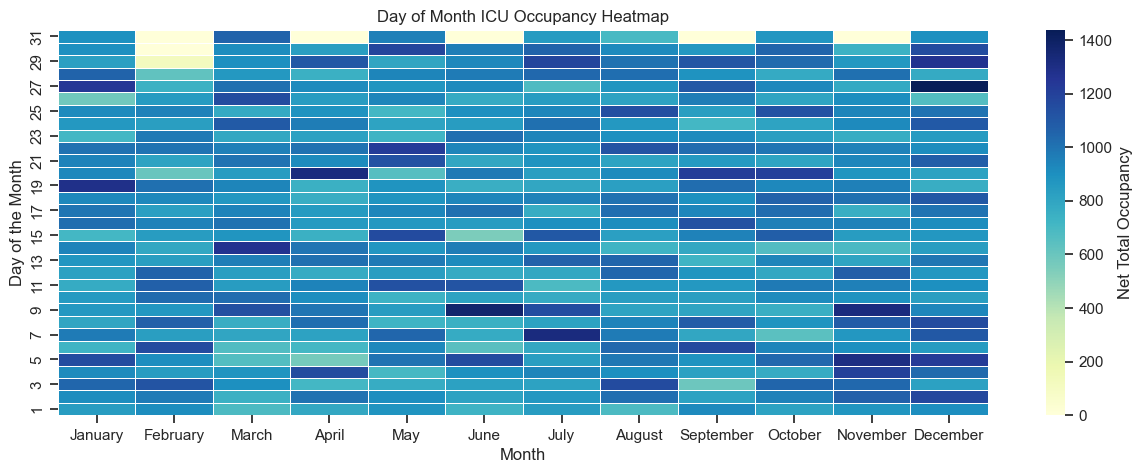

In [62]:
# Pivot the data for the heatmap
heatmap_data = df_day_mo.pivot_table(
    index=['day'], 
    columns=['mo'], 
    values='count',
    fill_value=0
)

heatmap_data = heatmap_data.reindex(index=heatmap_data.index[::-1])

# Plot the heatmap
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, cbar=True, cbar_kws={'label':'Net Total Occupancy'}, linewidths=.5)

# Set ticks
ax.set_xticklabels([calendar.month_name[i] for i in range(1, 13)])

# Set labels
plt.xlabel('Month')
plt.ylabel('Day of the Month')
plt.title('Day of Month ICU Occupancy Heatmap')

plt.show()

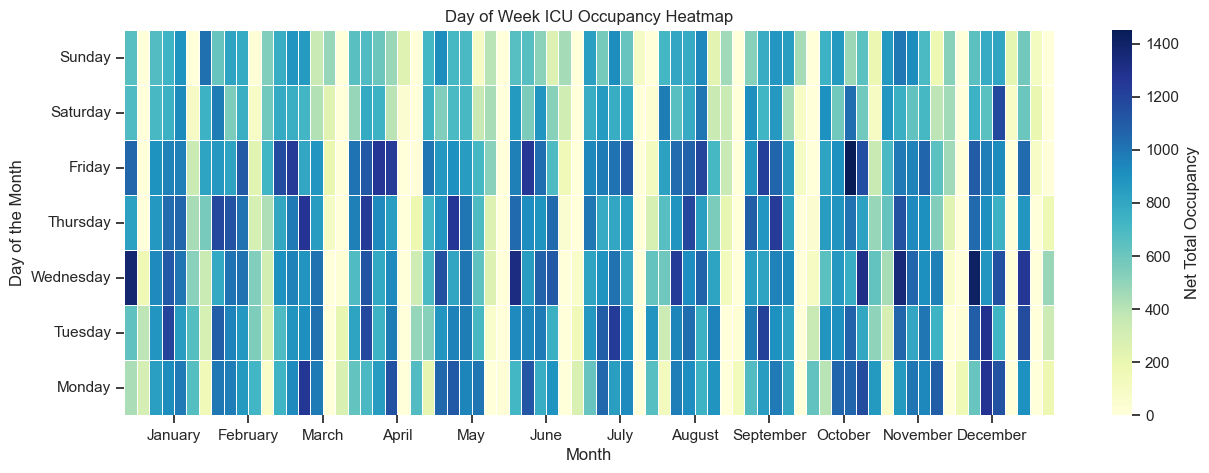

In [63]:
# Pivot the data for the heatmap
heatmap_data = df_dow_wk_mo.pivot_table(
    index=['dow'], 
    columns=['week', 'mo'], 
    values='count',
    fill_value=0
)

heatmap_data = heatmap_data.reindex(index=heatmap_data.index[::-1])

# Plot the heatmap
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, cbar=True, cbar_kws={'label':'Net Total Occupancy'}, linewidths=.5)

# Set ticks
ax.set_xticks(np.arange(4, 72, 6))
ax.set_xticklabels([calendar.month_name[i] for i in range(1, 13)], rotation=0)
ax.set_yticklabels([calendar.day_name[i] for i in range(7)][::-1], rotation=0)

# Set labels
plt.xlabel('Month')
plt.ylabel('Day of the Month')
plt.title('Day of Week ICU Occupancy Heatmap')

plt.show()

# **Plot Cumulative ICU Occupancy year round by week**

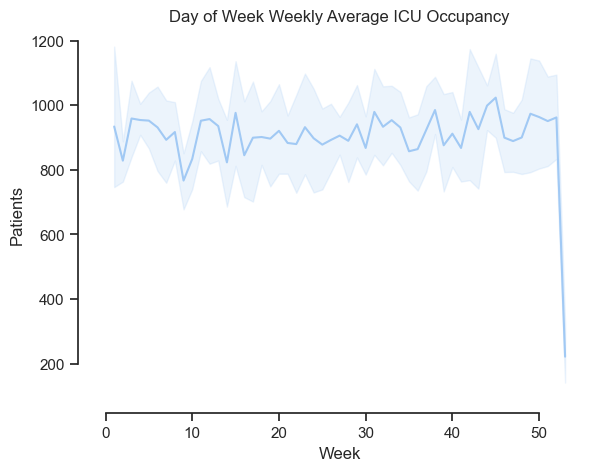

In [71]:
df_dow_wk = df_dow_wk.rename(columns={'dow':'Day of Week', 'week':'Week', 'count': 'Patients'})
sns.lineplot(df_dow_wk, x='Week', y='Patients')
sns.despine(offset=10, trim=True)

plt.title('Day of Week Weekly Average ICU Occupancy')
plt.show()

# **Plot Weekly Cumulative ICU Occupancy**

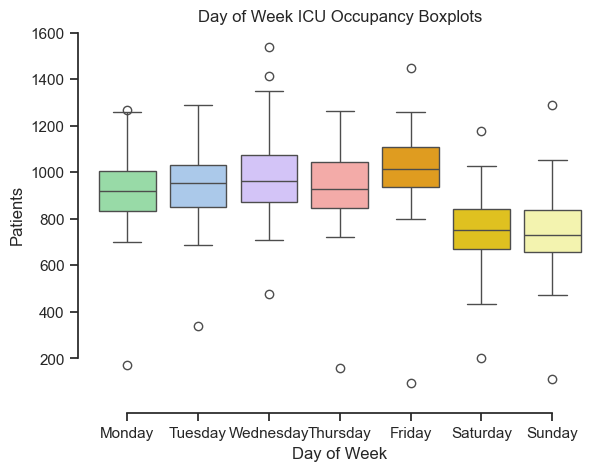

In [72]:
fig, ax = plt.subplots()
sns.boxplot(df_dow_wk, x='Day of Week', y='Patients', hue='Day of Week',  palette=["g", "b", "m", 'r', 'orange', 'gold', 'y'])
sns.despine(offset=10, trim=True)
ax.set_xticklabels([calendar.day_name[i] for i in range(7)])
plt.title('Day of Week ICU Occupancy Boxplots')
ax.legend_.remove()
plt.show()